In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv(r"C:\Users\raund\OneDrive\Documents\Quantim Data Analytics\QVI_data.csv")

# Convert date column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Create a month column
df['MONTH'] = df['DATE'].dt.to_period('M').astype(str)


In [7]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


In [2]:
monthly = df.groupby(['STORE_NBR', 'MONTH']).agg(
    TOT_SALES=('TOT_SALES', 'sum'),
    N_CUSTOMERS=('LYLTY_CARD_NBR', 'nunique'),
    N_TXNS=('TXN_ID', 'count')
).reset_index()

monthly['TXNS_PER_CUST'] = monthly['N_TXNS'] / monthly['N_CUSTOMERS']


In [3]:
from scipy.stats import pearsonr

def find_best_control_store(trial_store, metric):
    trial_series = monthly[monthly['STORE_NBR'] == trial_store][['MONTH', metric]].set_index('MONTH')

    correlations = {}

    for store in monthly['STORE_NBR'].unique():
        if store == trial_store:
            continue
        control_series = monthly[monthly['STORE_NBR'] == store][['MONTH', metric]].set_index('MONTH')
        merged = trial_series.join(control_series, lsuffix='_trial', rsuffix='_control', how='inner')

        if len(merged) >= 6:  # require some overlap
            r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
            correlations[store] = r

    best_store = max(correlations, key=correlations.get)
    return best_store


In [4]:
trial_stores = [77, 86, 88]
metrics = ['TOT_SALES', 'N_CUSTOMERS', 'TXNS_PER_CUST']

control_map = {}

for store in trial_stores:
    control_map[store] = {}
    for metric in metrics:
        control = find_best_control_store(store, metric)
        control_map[store][metric] = control

import pprint
pprint.pprint(control_map)


C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2066815788.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2066815788.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2066815788.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2066815788.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
C:\Users\raund\AppData\Local\Temp\ipykernel_14596\206681

{77: {'N_CUSTOMERS': 35, 'TOT_SALES': 41, 'TXNS_PER_CUST': 152},
 86: {'N_CUSTOMERS': 147, 'TOT_SALES': 159, 'TXNS_PER_CUST': 244},
 88: {'N_CUSTOMERS': 35, 'TOT_SALES': 159, 'TXNS_PER_CUST': 201}}


C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2066815788.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2066815788.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2066815788.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])


In [5]:
trial_period = ['2019-02', '2019-03', '2019-04']

def compare_stores(trial_store, control_store):
    trial_data = monthly[(monthly['STORE_NBR'] == trial_store) & (monthly['MONTH'].isin(trial_period))]
    control_data = monthly[(monthly['STORE_NBR'] == control_store) & (monthly['MONTH'].isin(trial_period))]

    print(f"\n📊 Trial Store {trial_store} vs Control Store {control_store} (Feb–Apr 2019)")
    print("Total Sales:")
    print("Trial:\n", trial_data[['MONTH', 'TOT_SALES']])
    print("Control:\n", control_data[['MONTH', 'TOT_SALES']])

    from scipy.stats import ttest_ind
    t_stat, p_val = ttest_ind(trial_data['TOT_SALES'], control_data['TOT_SALES'])
    print(f"T-Test p-value: {p_val:.4f} → {'Significant' if p_val < 0.05 else 'Not significant'}")

# Example for store 77
compare_stores(77, control_map[77]['TOT_SALES'])



📊 Trial Store 77 vs Control Store 41 (Feb–Apr 2019)
Total Sales:
Trial:
        MONTH  TOT_SALES
887  2019-02      235.0
888  2019-03      278.5
889  2019-04      263.5
Control:
        MONTH  TOT_SALES
467  2019-02      234.6
468  2019-03      226.2
469  2019-04      231.3
T-Test p-value: 0.0949 → Not significant


C:\Users\raund\AppData\Local\Temp\ipykernel_14596\1630431237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Store Type'] = plot_data['STORE_NBR'].apply(lambda x: 'Trial' if x == trial_store else 'Control')


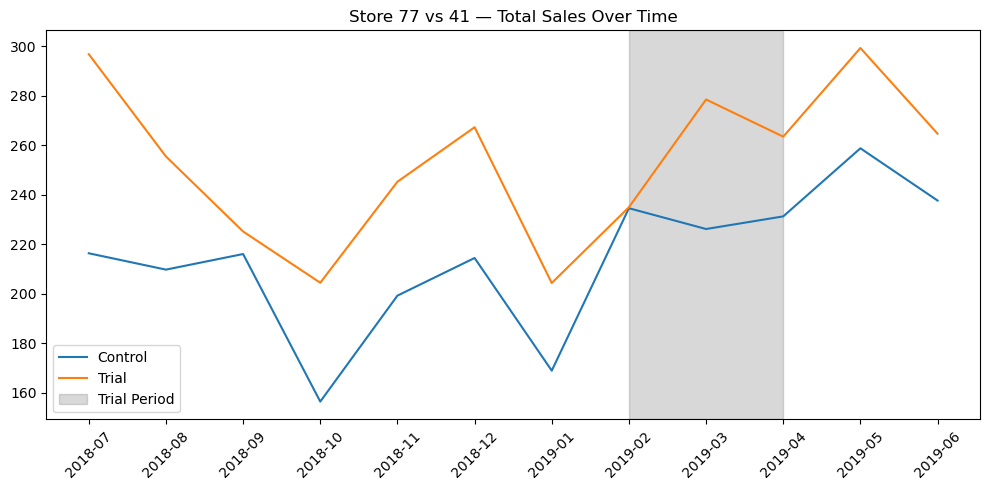

In [6]:
import matplotlib.pyplot as plt

def plot_trial_vs_control(trial_store, control_store):
    plot_data = monthly[
        (monthly['STORE_NBR'].isin([trial_store, control_store])) &
        (monthly['MONTH'] >= '2018-07') &
        (monthly['MONTH'] <= '2019-06')
    ]

    plot_data['Store Type'] = plot_data['STORE_NBR'].apply(lambda x: 'Trial' if x == trial_store else 'Control')

    plt.figure(figsize=(10, 5))
    for key, grp in plot_data.groupby('Store Type'):
        plt.plot(grp['MONTH'], grp['TOT_SALES'], label=key)

    plt.axvspan('2019-02', '2019-04', color='gray', alpha=0.3, label='Trial Period')
    plt.xticks(rotation=45)
    plt.title(f"Store {trial_store} vs {control_store} — Total Sales Over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_trial_vs_control(77, control_map[77]['TOT_SALES'])


In [10]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


In [14]:
import pandas as pd

# Assuming df is your merged dataframe that includes 'DATE', 'STORE_NBR', 'TOT_SALES', 'LYLTY_CARD_NBR'
df['DATE'] = pd.to_datetime(df['DATE'])  # Ensure DATE is in datetime format
df['MONTH'] = df['DATE'].dt.to_period('M').astype(str)

# Group by MONTH and STORE_NBR to compute metrics
monthly_metrics = df.groupby(['MONTH', 'STORE_NBR']).agg(
    TOT_SALES=('TOT_SALES', 'sum'),
    N_CUSTOMERS=('LYLTY_CARD_NBR', 'nunique'),
    NUM_TRANSACTIONS=('LYLTY_CARD_NBR', 'count')
).reset_index()

# Calculate average transactions per customer
monthly_metrics['AVG_TXNS_PER_CUSTOMER'] = monthly_metrics['NUM_TRANSACTIONS'] / monthly_metrics['N_CUSTOMERS']

# Preview result
print(monthly_metrics.head())


     MONTH  STORE_NBR  TOT_SALES  N_CUSTOMERS  NUM_TRANSACTIONS  \
0  2018-07          1      206.9           49                52   
1  2018-07          2      150.8           39                41   
2  2018-07          3     1205.7          112               138   
3  2018-07          4     1399.9          128               160   
4  2018-07          5      812.0           93               120   

   AVG_TXNS_PER_CUSTOMER  
0               1.061224  
1               1.051282  
2               1.232143  
3               1.250000  
4               1.290323  


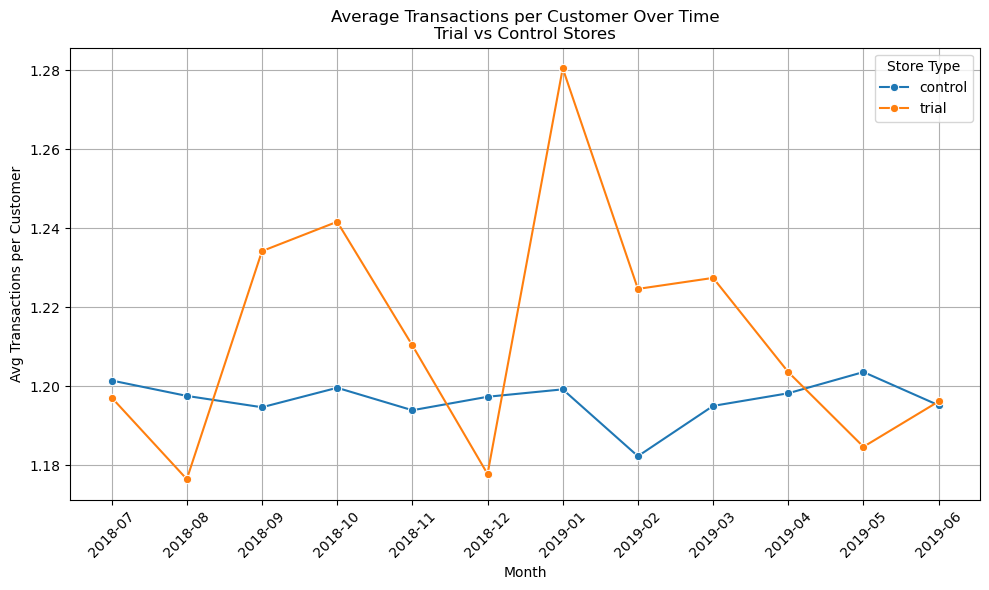

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure DATE is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.to_period('M').astype(str)

# Add store_type column if not already present
trial_stores = [77, 86, 88]
df['store_type'] = df['STORE_NBR'].apply(lambda x: 'trial' if x in trial_stores else 'control')

# Group by month and store_type
monthly_metrics = df.groupby(['MONTH', 'store_type']).agg(
    N_CUSTOMERS=('LYLTY_CARD_NBR', 'nunique'),
    NUM_TRANSACTIONS=('LYLTY_CARD_NBR', 'count')
).reset_index()

# Calculate average transactions per customer
monthly_metrics['AVG_TXNS_PER_CUSTOMER'] = monthly_metrics['NUM_TRANSACTIONS'] / monthly_metrics['N_CUSTOMERS']

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_metrics, x='MONTH', y='AVG_TXNS_PER_CUSTOMER', hue='store_type', marker='o')

plt.title('Average Transactions per Customer Over Time\nTrial vs Control Stores')
plt.xlabel('Month')
plt.ylabel('Avg Transactions per Customer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend(title='Store Type')
plt.show()


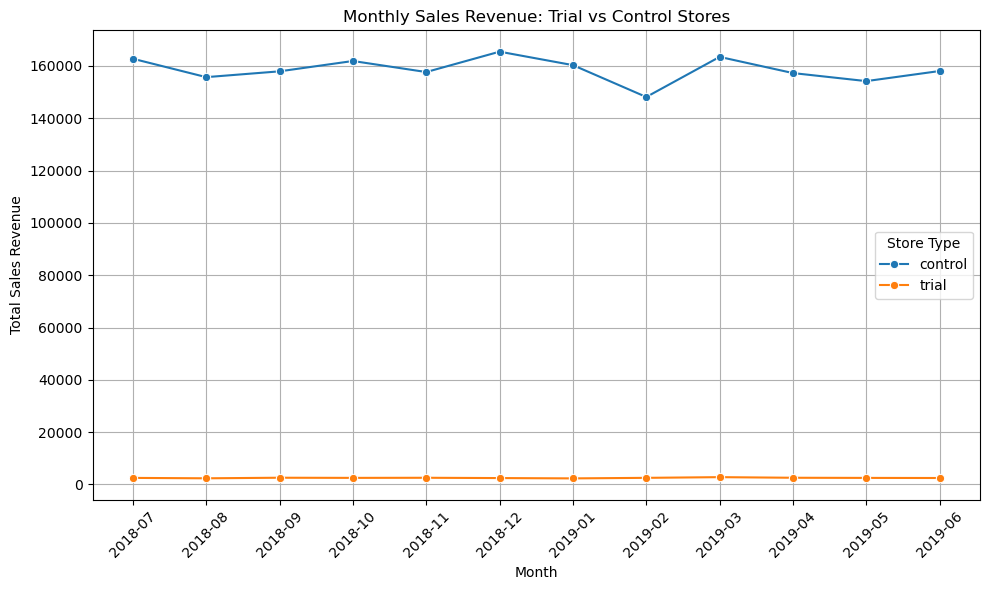

In [18]:
# Group data
monthly_sales = df.groupby(['MONTH', 'store_type'])['TOT_SALES'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='MONTH', y='TOT_SALES', hue='store_type', marker='o')
plt.title('Monthly Sales Revenue: Trial vs Control Stores')
plt.xlabel('Month')
plt.ylabel('Total Sales Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Store Type')
plt.show()


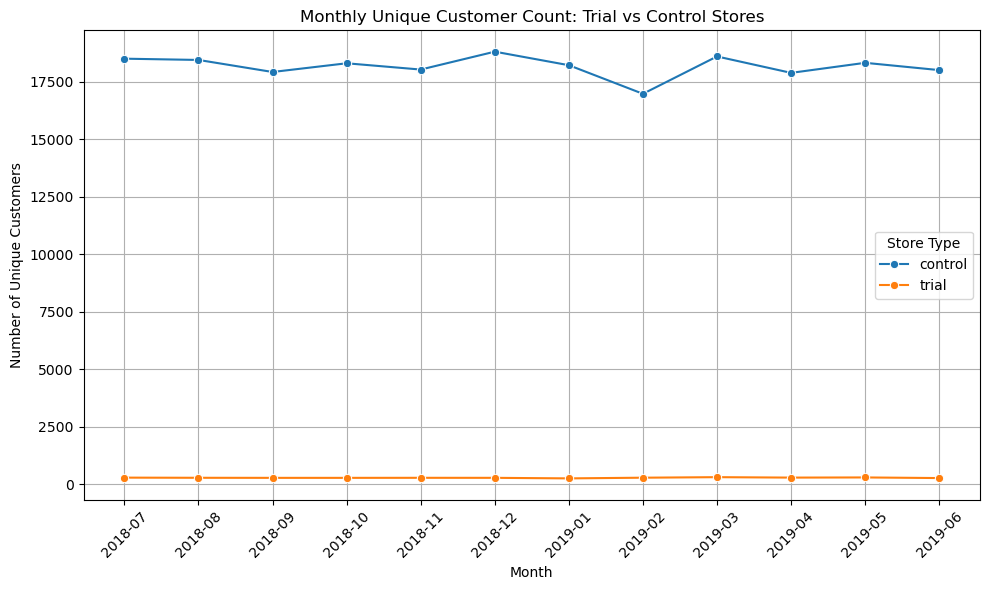

In [19]:
# Group data
monthly_customers = df.groupby(['MONTH', 'store_type'])['LYLTY_CARD_NBR'].nunique().reset_index()
monthly_customers.rename(columns={'LYLTY_CARD_NBR': 'N_CUSTOMERS'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_customers, x='MONTH', y='N_CUSTOMERS', hue='store_type', marker='o')
plt.title('Monthly Unique Customer Count: Trial vs Control Stores')
plt.xlabel('Month')
plt.ylabel('Number of Unique Customers')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Store Type')
plt.show()


C:\Users\raund\AppData\Local\Temp\ipykernel_14596\2359219201.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pivot_sales, x='MONTH', y='SALES_DIFF', palette='coolwarm')


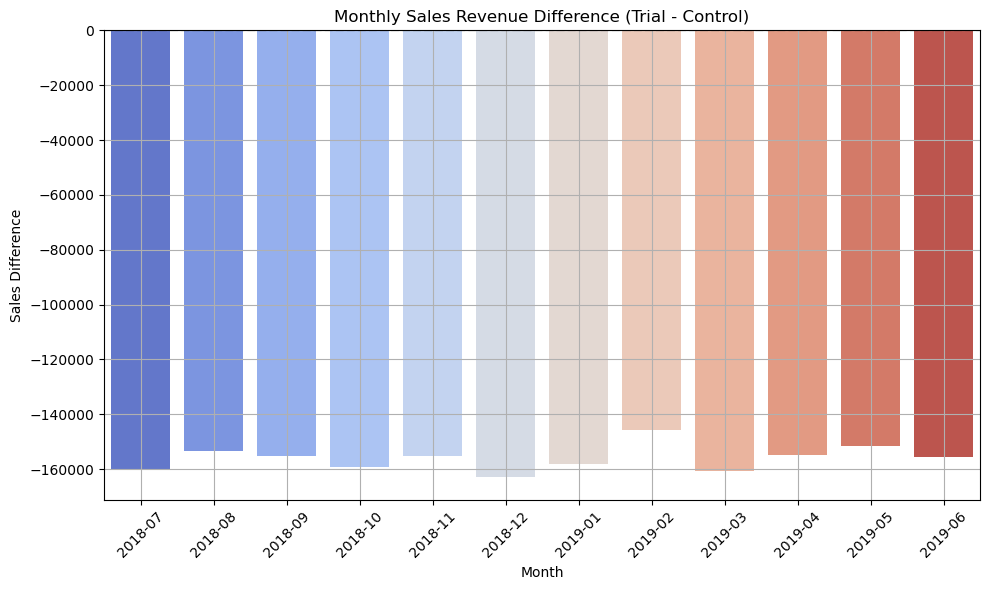

In [20]:
# First, pivot sales by month and store_type
pivot_sales = monthly_sales.pivot(index='MONTH', columns='store_type', values='TOT_SALES').reset_index()

# Calculate the difference
pivot_sales['SALES_DIFF'] = pivot_sales['trial'] - pivot_sales['control']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_sales, x='MONTH', y='SALES_DIFF', palette='coolwarm')
plt.title('Monthly Sales Revenue Difference (Trial - Control)')
plt.xlabel('Month')
plt.ylabel('Sales Difference')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()
